In [ ]:
import os
import warnings
from argparse import ArgumentParser

import mmcv
from mmcv import Config, DictAction
from mmcv.runner import load_checkpoint

from mmpose.apis import (inference_top_down_pose_model, init_pose_model,
                         vis_pose_result)
from mmpose.datasets import build_dataset, build_dataloader
from mmpose.models import build_posenet

config = "configs/sharpose_base_coco_256x192_4xb64_210e.py"
ckpt = "checkpoints/pose/sharpose_coco_384x288_b_alpha0.3.pth"

cfg = Config.fromfile(config)
cfg.data.test.data_cfg.use_gt_bbox = True
cfg.model.test_cfg.flip_test = False
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
loader_cfg = {
        **dict(seed=cfg.get('seed'), drop_last=False, dist=False),
        **dict((k, cfg.data[k]) for k in [
                   'seed',
                   'prefetch_num',
                   'pin_memory',
                   'persistent_workers',
               ] if k in cfg.data)
    }
test_loader_cfg = {
    **loader_cfg,
    **dict(shuffle=False, drop_last=False),
    **dict(workers_per_gpu=cfg.data.get('workers_per_gpu', 1)),
    **dict(samples_per_gpu=cfg.data.get('samples_per_gpu', 1)),
    **cfg.data.get('test_dataloader', {})
}
dataloader = build_dataloader(dataset, **test_loader_cfg)

model = build_posenet(cfg.model)
load_checkpoint(model, ckpt, map_location='cpu')
model.cfg = cfg
model.to('cuda')
model.eval()


loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
=> num_images: 5000
=> load 6352 samples
load checkpoint from local path: ./work_dirs/vit_cftk_qpft90_coco_128x96_to_256x192_alpha0.5_210e_qpft/latest.pth


TopDown(
  (backbone): CFTKQPViT(
    (patch_embed): MultiResoPatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_embed_list): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 1x48x768 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 1x192x768 (GPU 0)]
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True

In [99]:
import torch
import torch.nn.functional as F
from torchvision.transforms import ToPILImage
from PIL import Image
from xtcocotools.coco import COCO
from mmpose.datasets import DatasetInfo

# 130
# for x in dataset:
coco_kp_dict = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear',
    4: 'right_ear',
    5: 'left_shoulder',
    6: 'right_shoulder',
    7: 'left_elbow',
    8: 'right_elbow',
    9: 'left_wrist',
    10: 'right_wrist',
    11: 'left_hip',
    12: 'right_hip',
    13: 'left_knee',
    14: 'right_knee',
    15: 'left_ankle',
    16: 'right_ankle'}

avg_body = 0
avg_img = 0

all_body = []

for i in range(0, len(dataset), 20):
    x = dataset[i]
    img = x['img']
    meta = x['img_metas']._data
    # print(meta)
    feature = model.backbone.forward(x['img'].cuda().unsqueeze(0))
    heatmap = model.keypoint_head.forward(feature)

    # get attention map
    out = model.backbone.global_attention.sum([0, 1])[:1, 1:].sum(0)
    all_body.append(out)

    out = model.backbone.global_attention.sum([0, 1])[:1, 18:].sum(0)
    avg_img += out
    # out = out.reshape(*model.backbone.patch_embed.patch_shapes[0])
    # out = out.pow(0.5)
    # out = F.interpolate(out[None, None, ...], scale_factor=32.0, mode='nearest')[0]
    # out = out.detach().cpu()

    # mean=torch.Tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    # std=torch.Tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    # img = img.mul(std).add(mean)

    # img_rgba = torch.cat([img, out])
    # ToPILImage()(img_rgba)
total = len(dataset) // 50

all_body = torch.stack(all_body)

out = avg_img / total
out = out.reshape(*model.backbone.patch_embed.patch_shapes[0])
out = out.pow(0.5)
out = F.interpolate(out[None, None, ...], scale_factor=32.0, mode='nearest')[0]
out = out.detach().cpu()


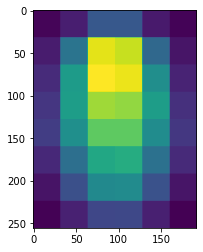

: 

In [107]:

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
color = px.colors.qualitative.Plotly
import numpy as np

fig = go.Figure()

draw_body = all_body.detach().cpu()

joint_dict = dict()

for k, v in coco_kp_dict.items():
    joint = v.split("_")[-1]
    if joint in joint_dict:
        joint_dict[joint].append(k)
    else:
        joint_dict[joint] = [k]

for joint, keys in joint_dict.items():
    fig.add_trace(go.Box(y=draw_body[:, keys].mean(-1), name=joint, boxpoints=False, marker_color=color[0]))
fig.add_trace(go.Box(y=draw_body[:, 18:].mean(-1), name="image", boxpoints=False, marker_color=color[0]))
fig.update_layout(showlegend=False,    
                  font_color="black",
                  font_family="Times New Roman",
                  title_font_family="Times New Roman",
                  margin_l=0, margin_r=0, margin_t=12, margin_b=0,)
fig.show()
fig.write_image("qp_attn.pdf", width=350, height=190)

plt.imshow(out[0])


In [ ]:
joint_dict = dict()

for k, v in coco_kp_dict.items():
    joint = v.split("_")[-1]
    if joint in joint_dict:
        joint_dict[joint].append(k)
    else:
        joint_dict[joint] = [k]

for joint, keys in joint_dict.items():
    print(f"{joint}\t{avg_body[keys].sum():.2f}")



nose	0.04
eye	0.09
ear	0.07
shoulder	0.11
elbow	0.17
wrist	0.11
hip	0.17
knee	0.12
ankle	0.12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


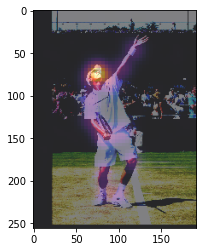

In [ ]:
import matplotlib.pyplot as plt

stride = 5
stage = 1

hm = heatmap[stage][0, ...].mean(0)
hm = hm.repeat_interleave(4, 0).repeat_interleave(4, 1)
plt.imshow(x['img'].permute(1, 2, 0), alpha=0.7)
plt.imshow(hm.detach().cpu(), alpha=0.5, cmap="inferno")
    

torch.Size([17, 256, 192])


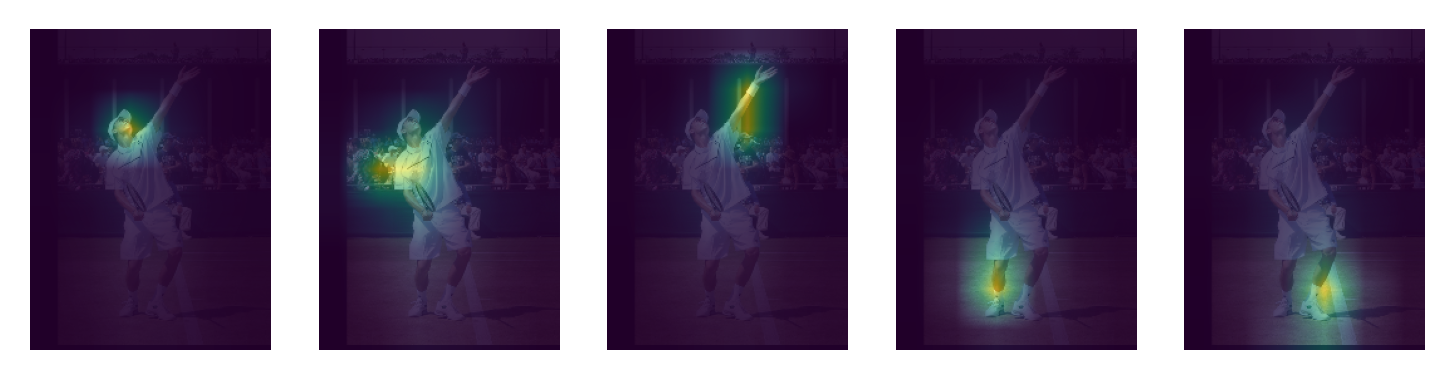

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn.functional as F


mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = (6.0, 4.0)
alpha = 0.3

mean=torch.Tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
std=torch.Tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)

out = model.backbone.global_attention.sum([0, 1])[:17, 17:].reshape(17, *model.backbone.patch_embed.patch_shapes[0]).detach().cpu()
out = F.interpolate(out[None, ...], scale_factor=32.0, mode='bilinear')[0]
print(out.shape)
# out = out.repeat_interleave(32, 1).repeat_interleave(32, 2)
img = x['img']
img = img.mul(std).add(mean).permute(1, 2, 0)

# selection = [*range(0, 17, 1)]
selection = [0, 6, 7, 14, 15]
fig, axs = plt.subplots(1, len(selection))
for attn, ax in zip(out[selection], axs):
    ax.imshow(img * torch.pow(attn[..., None] / attn.max(), 0.6), alpha=1.0)
    ax.imshow(attn, alpha=0.5)
    ax.axis('off')
fig.show()

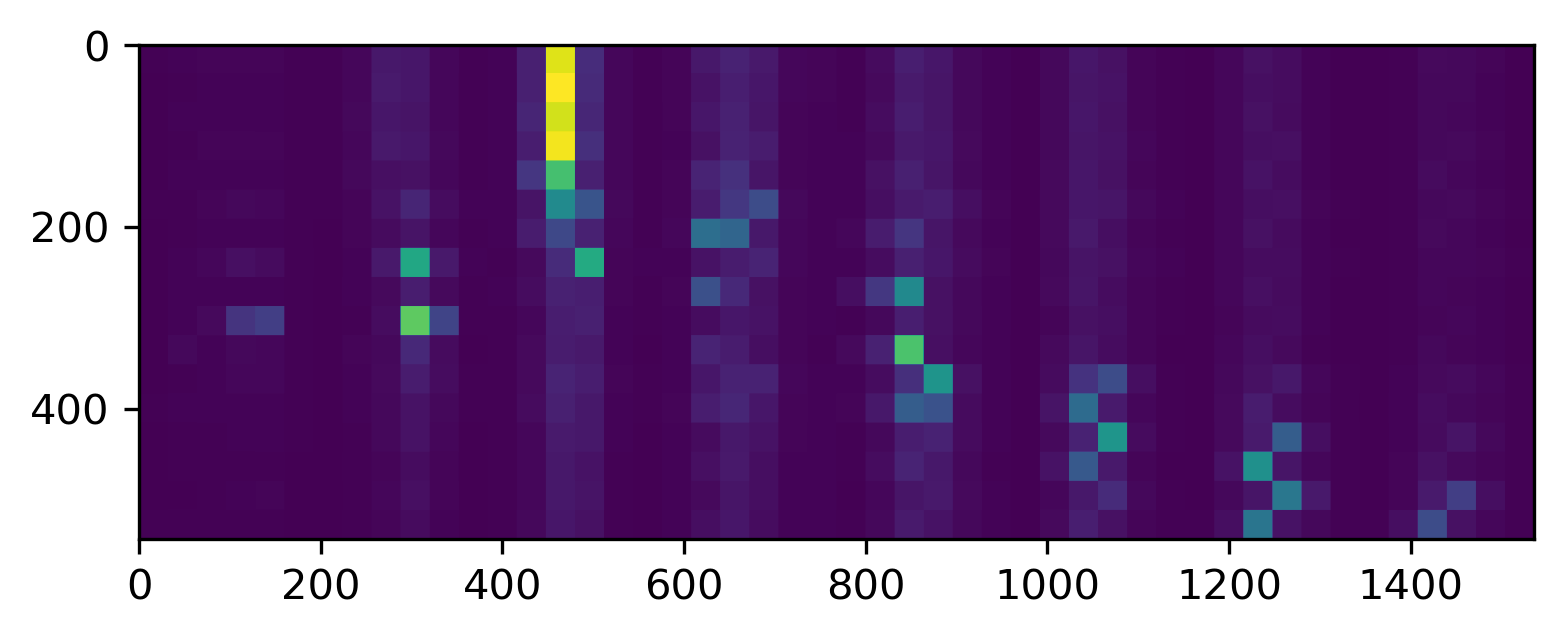

In [ ]:
out = model.backbone.global_attention.sum([0, 1])[:17, 17:]
out = out.repeat_interleave(32, 0).repeat_interleave(32, 1).detach().cpu()
plt.imshow(out)